Creating heatmaps from the positions recorded by my GPS watch

In [1]:
using DIVAnd
using PyPlot
using PyCall
using Geodesy
using DataFrames
using CSV
using GeoArrays
push!(LOAD_PATH, pwd())
using GPXheat
using Statistics
cmocean = pyimport("cmocean")

┌ Info: Precompiling GPXheat [top-level]
└ @ Base loading.jl:1313


PyObject <module 'cmocean' from '/home/ctroupin/.julia/conda/3/lib/python3.7/site-packages/cmocean/__init__.py'>

## Files and directories

In [2]:
datadir = "../Data/"
outputdir = "../Data/Rain/"
datafile = joinpath(datadir, "Pluviometria.csv") 

"../Data/Pluviometria.csv"

In [24]:
df = DataFrame(CSV.File(datafile));
xcoords = df."X-UTM"
ycoords = df."Y-UTM"
precip = df."Media Anual (mm)";
pmean = mean(precip)

334.13703703703703

### Convert coordinates from UTM to lon/lat

In [4]:
function convert_coord(xcoords, ycoords)
    npts = length(xcoords)
    lon = Array{Float64}(undef, npts)
    lat = Array{Float64}(undef, npts);
    utm_canary = LLAfromUTM(28, true, wgs84)
    for iii=1:npts
        coords = utm_canary(UTM(xcoords[iii], ycoords[iii]))
        lon[iii] = coords.lon 
        lat[iii] = coords.lat 
    end
    
    return lon, lat
end

convert_coord (generic function with 1 method)

In [5]:
lon, lat = convert_coord(xcoords, ycoords);

## Interpolation
### Domain and resolution

In [7]:
# Canary islands
bathfile = "/media/ctroupin/My Passport/data/EMODnet/Bathymetry/G3_2018.dtm"
longrid = -15.9:0.0005:-15.3
latgrid = 27.7:0.0005:28.2
isfile(bathfile)

true

### Create mask and compute metrics

In [8]:
mask0, (pm,pn), (xi,yi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid);
mask_emodnet = GPXheat.create_mask_emodnet(bathfile, longrid, latgrid);

  0.188042 seconds (321.86 k allocations: 20.820 MiB, 99.66% compilation time)


### Computation
#### 1. Uniform inflation

In [19]:
rain_anom_interp, s = DIVAndrun(mask_emodnet, (pm, pn), (xi, yi), (lon, lat), Float64.(precip) .- pmean, 
    0.025, 1);

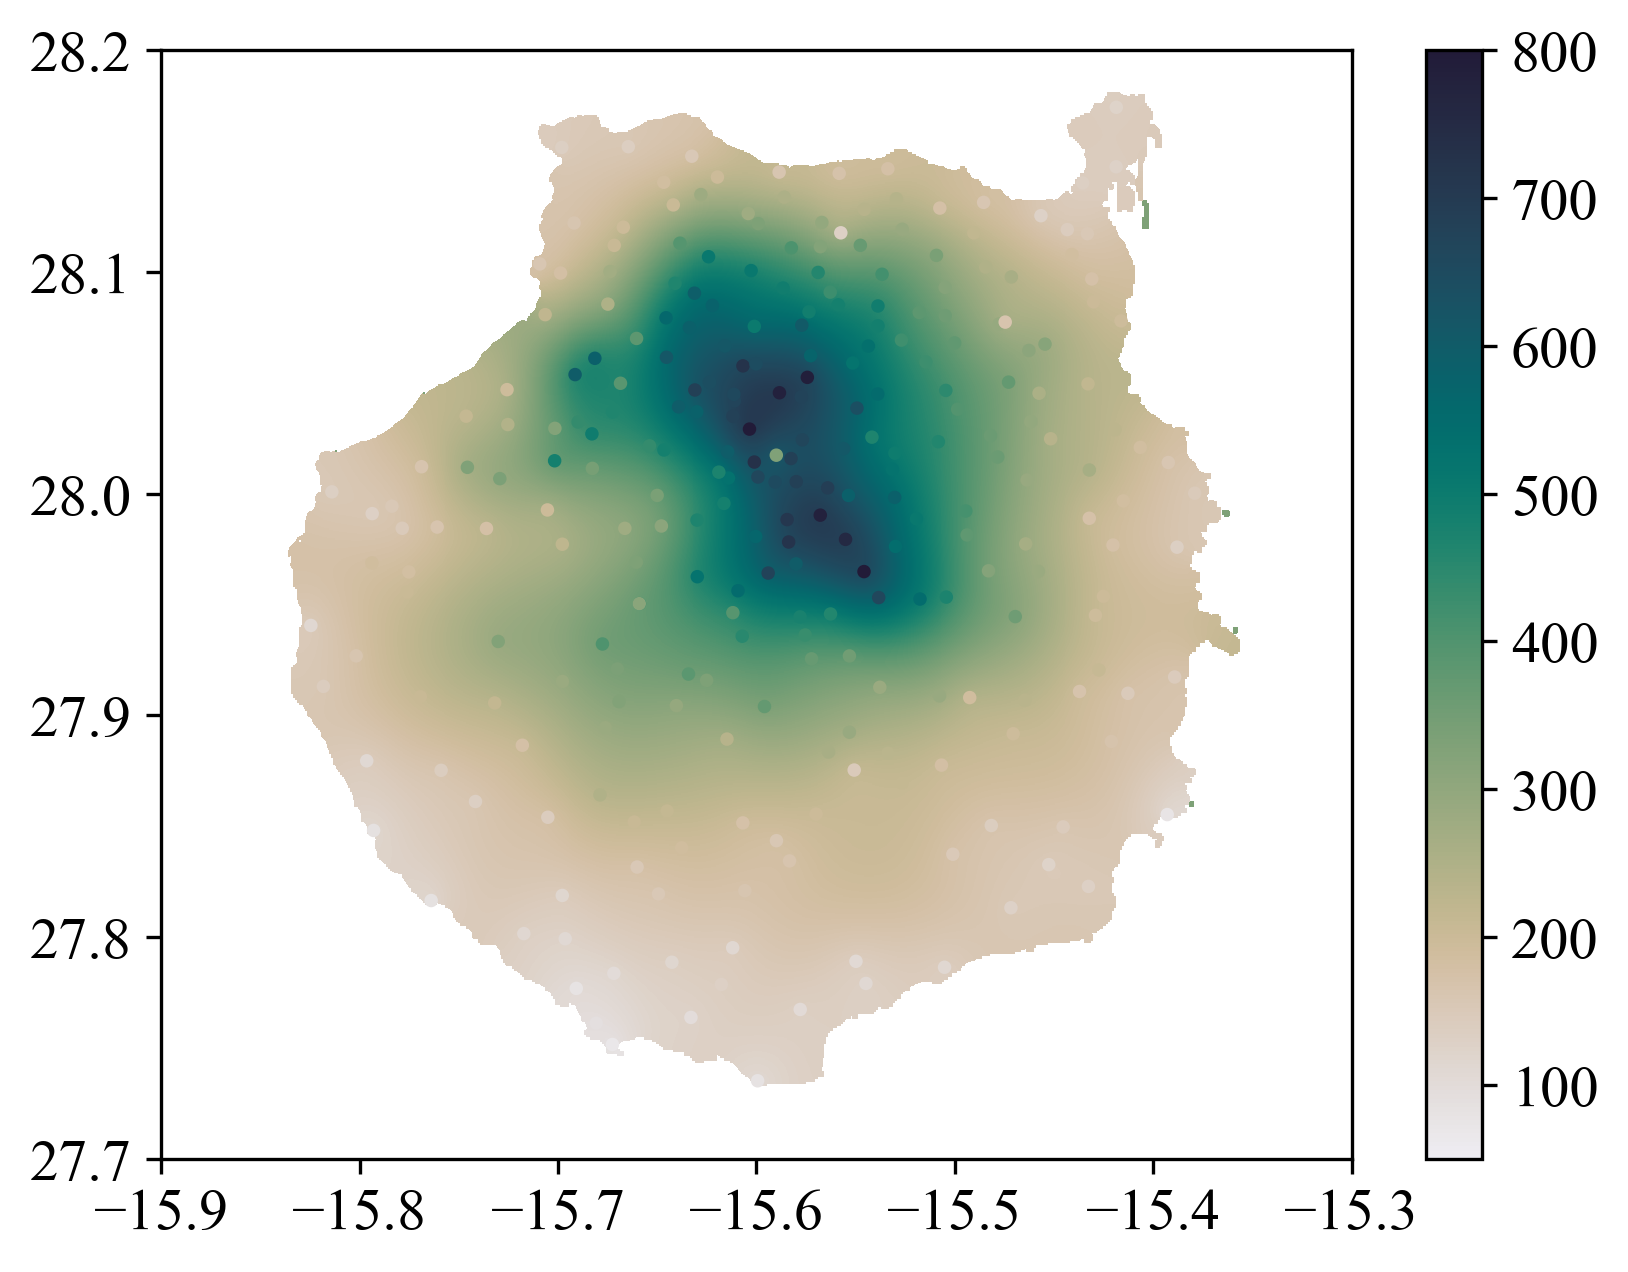

In [25]:
rain_interp = rain_anom_interp .+ pmean
pcm = pcolormesh(longrid, latgrid, rain_interp', vmin=50., vmax=800., cmap=cmocean.cm.rain)
scatter(lon, lat, c=precip, s=5, vmin=50., vmax=800., cmap=cmocean.cm.rain)
colorbar(pcm)
show()

## Save results in netCDF files

In [23]:
GPXheat.write_nc_heat(joinpath(outputdir, "GC_rain01.nc"), longrid, latgrid, rain_interp .+ pmean; valex=-999.9)

27.7:0.0005:28.2

### Save results as geoTIFF

In [32]:
using GeoArrays
using FilePaths

In [43]:
function write_geotiff(outputfile::String, fi::Matrix{Float64}, xi::Matrix{Float64}, yi::Matrix{Float64}; epsg=4326)
    ga = GeoArray(rain_interp)
    bbox!(ga, (min_x=minimum(longrid), min_y=minimum(latgrid),  max_x=maximum(longrid), max_y=maximum(latgrid)))
    epsg!(ga, epsg)
    GeoArrays.write!(outputfile, ga)
end

write_geotiff (generic function with 1 method)

In [46]:
outputfile = "/home/ctroupin/test2delete.tiff"
@time write_geotiff(outputfile, rain_anom_interp, xi, yi, epsg=4326);

  0.300999 seconds (188 allocations: 18.356 MiB)


PosixPath